<a href="https://colab.research.google.com/github/lacykaltgr/ait-assessments/blob/main/AIT_11_Author_classification_with_attention_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [ ]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt"
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt"
urlretrieve(book1, 'book1.txt')
urlretrieve(book2, 'book2.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [ ]:
chars = sorted(list(set(book1_text+book2_text)))
print(len(chars))

99


In [ ]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print ("Indices to char dictionary:", indices_char)

Indices to char dictionary: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '=', 29: '?', 30: '[', 31: ']', 32: '_', 33: 'a', 34: 'b', 35: 'c', 36: 'd', 37: 'e', 38: 'f', 39: 'g', 40: 'h', 41: 'i', 42: 'j', 43: 'k', 44: 'l', 45: 'm', 46: 'n', 47: 'o', 48: 'p', 49: 'q', 50: 'r', 51: 's', 52: 't', 53: 'u', 54: 'v', 55: 'w', 56: 'x', 57: 'y', 58: 'z', 59: '{', 60: '}', 61: 'à', 62: 'â', 63: 'æ', 64: 'è', 65: 'é', 66: 'ê', 67: 'ë', 68: 'ö', 69: 'ú', 70: 'ü', 71: 'œ', 72: 'α', 73: 'γ', 74: 'δ', 75: 'ε', 76: 'η', 77: 'ι', 78: 'λ', 79: 'ν', 80: 'ξ', 81: 'ο', 82: 'π', 83: 'ρ', 84: 'ς', 85: 'σ', 86: 'τ', 87: 'υ', 88: 'χ', 89: 'ῆ', 90: 'ῦ', 91: '—', 92: '‘', 93: '’', 94: '“', 95: '”', 96: '•', 97: '™', 98: '\ufeff'}


In [ ]:
seq_len = 60
step = 30
sentences_1 = []
sentences_2 = []

for i in range(0, len(book1_text)-seq_len, step):
    sentences_1.append(book1_text[i:i+seq_len])
for i in range(0, len(book2_text)-seq_len, step):
    sentences_2.append(book2_text[i:i+seq_len])



In [ ]:
sentences_1_len = len(sentences_1)
sentences_2_len = len(sentences_2)
totallen = len(sentences_1) + len(sentences_2)

In [ ]:
X_1 = np.zeros((sentences_1_len, seq_len, len(chars)), dtype =float)
X_2 = np.zeros((sentences_2_len, seq_len, len(chars)), dtype =float)
Y_1 = np.zeros((sentences_1_len,2), dtype=float)
Y_2 = np.zeros((sentences_2_len,2), dtype=float)

for i, sentence in enumerate(sentences_1):
    for t, char in enumerate(sentence): 
        X_1[i,t,char_indices[char]] = 1
    Y_1[i,0] = 1

for i, sentence in enumerate(sentences_2):
    for t, char in enumerate(sentence): 
        X_2[i,t,char_indices[char]] = 1
    Y_2[i,1] = 1

## Data splitting
Split the data into train, validate and test sets. Make 

In [ ]:
val_ratio  = 0.1
test_ratio = 0.1

v_split_1  = int((1-val_ratio-test_ratio) * sentences_1_len)
v_split_2  = int((1-val_ratio-test_ratio) * sentences_2_len)
t_split_1  = int((1-test_ratio) * sentences_1_len)
t_split_2  = int((1-test_ratio) * sentences_2_len)

X_train = np.concatenate((X_1[:v_split_1], X_2[:v_split_2]), axis=0)
X_valid = np.concatenate((X_1[v_split_1:t_split_1], X_2[v_split_2:t_split_2]), axis=0)
X_test  = np.concatenate((X_1[t_split_1:], X_2[t_split_2:]), axis=0)

Y_train = np.concatenate((Y_1[:v_split_1], Y_2[:v_split_2]), axis=0)
Y_valid = np.concatenate((Y_1[v_split_1:t_split_1], Y_2[v_split_2:t_split_2]), axis=0)
Y_test  = np.concatenate((Y_1[t_split_1:], Y_2[t_split_2:]), axis=0)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], len(chars)),dropout=0.3,recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                16896     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 16,962
Trainable params: 16,962
Non-trainable params: 0
_________________________________________________________________


## Model training
Train the model and apply early stopping.

In [ ]:
model.fit(X_train, Y_train, 
          epochs=1000, batch_size=128, 
          # validation_split=0.2, # don't change the validation split
          validation_data=(X_valid,Y_valid),
          callbacks=[es],
          verbose=1)

Epoch 1/1000
184/184 [==============================] - 31s 147ms/step - loss: 0.4481 - accuracy: 0.7756 - val_loss: 0.1279 - val_accuracy: 0.9703
Epoch 2/1000
184/184 [==============================] - 25s 134ms/step - loss: 0.2721 - accuracy: 0.8883 - val_loss: 0.0831 - val_accuracy: 0.9717
Epoch 3/1000
184/184 [==============================] - 27s 147ms/step - loss: 0.2202 - accuracy: 0.9079 - val_loss: 0.0733 - val_accuracy: 0.9771
Epoch 4/1000
184/184 [==============================] - 25s 139ms/step - loss: 0.2041 - accuracy: 0.9147 - val_loss: 0.0699 - val_accuracy: 0.9788
Epoch 5/1000
184/184 [==============================] - 25s 138ms/step - loss: 0.1847 - accuracy: 0.9244 - val_loss: 0.0668 - val_accuracy: 0.9812
Epoch 6/1000
184/184 [==============================] - 27s 145ms/step - loss: 0.1768 - accuracy: 0.9255 - val_loss: 0.0667 - val_accuracy: 0.9826
Epoch 7/1000
184/184 [==============================] - 25s 135ms/step - loss: 0.1732 - accuracy: 0.9261 - val_loss: 0

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [ ]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

92/92 [==============================] - 1s 12ms/step - loss: 1.0660 - accuracy: 0.7890
Test loss: 1.06602942943573
Test accuracy: 0.7890064716339111


## Confusion matrix
Calculate and display the confusion matrix.

92/92 [==============================] - 1s 11ms/step


<Axes: >

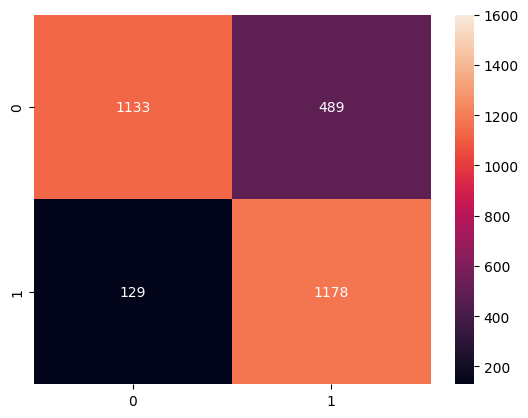

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=1600)

# Exercise: Attention mechanism

In [ ]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    
    # The constructor just calls the parent class's constructor
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
        
        
    # in the build, we have to define the weigths of the attention mechanism
    def build(self,input_shape): # (batch, seq_length, lstm_size) # (None, 60, 128)
        self.w=self.add_weight(name="att_weight",shape=(<TODO>,1),initializer="normal") # should be (lstm_size,1), use input_shape only 
        self.b=self.add_weight(name="att_bias",shape=(<TODO>,1),initializer="zeros") # should be (seq_length,1), use input_shape only 
        print("Attention weights' shape:",self.w.shape) 
        print("Attention bias' shape:",self.b.shape) 
        super(attention,self).build(input_shape)
        
        
    def call(self,x):
        et=<TODO> # dot product of x and attention weight + attention bias. Use 'K.' functions as tensorflow backend
        at=<TODO>  # softmax of et along the sequence axis. . Use 'K.' functions as tensorflow backend
        print(at.shape)
        output=<TODO> # multiply input x with the attention
        output=<TODO> # sum over the sequence axis to have lstm_size number of outputs. . Use 'K.' functions as tensorflow backend
        return output
    
    # gives back the main informations about the module
    def get_config(self):
        return super(attention,self).get_config()      

SyntaxError: ignored

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], len(chars)), return_sequences=True,dropout=0.3,recurrent_dropout=0.2))
model.add(attention())
model.add(Dense(2, activation='softmax'))


Attention weights' shape: (128, 1)
Attention bias' shape: (60, 1)
(None, 60, 1)
(None, 60, 1)
(None, 60, 128)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           116736    
                                                                 
 attention_5 (attention)     (None, 128)               188       
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 117,182
Trainable params: 117,182
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, Y_train, 
          epochs=1000, batch_size=128, 
          # validation_split=0.2, # don't change the validation split
          validation_data=(X_valid,Y_valid),
          callbacks=[es],
          verbose=1)

Epoch 1/1000
(None, 60, 1)
(None, 60, 1)
(None, 60, 128)
(None, 60, 1)
(None, 60, 1)
(None, 60, 128)
184/184 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8201(None, 60, 1)
(None, 60, 1)
(None, 60, 128)
184/184 [==============================] - 106s 559ms/step - loss: 0.3950 - accuracy: 0.8201 - val_loss: 0.1159 - val_accuracy: 0.9710
Epoch 2/1000
184/184 [==============================] - 98s 531ms/step - loss: 0.2592 - accuracy: 0.8990 - val_loss: 0.0876 - val_accuracy: 0.9778
Epoch 3/1000
184/184 [==============================] - 98s 531ms/step - loss: 0.1947 - accuracy: 0.9185 - val_loss: 0.0594 - val_accuracy: 0.9819
Epoch 4/1000
184/184 [==============================] - 98s 531ms/step - loss: 0.1661 - accuracy: 0.9262 - val_loss: 0.0534 - val_accuracy: 0.9822
Epoch 5/1000
184/184 [==============================] - 97s 527ms/step - loss: 0.1529 - accuracy: 0.9304 - val_loss: 0.0487 - val_accuracy: 0.9843
Epoch 6/1000
184/184 [==========================

In [ ]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

92/92 [==============================] - 3s 27ms/step - loss: 1.0338 - accuracy: 0.7887
Test loss: 1.0338410139083862
Test accuracy: 0.7886650562286377


92/92 [==============================] - 6s 62ms/step


<Axes: >

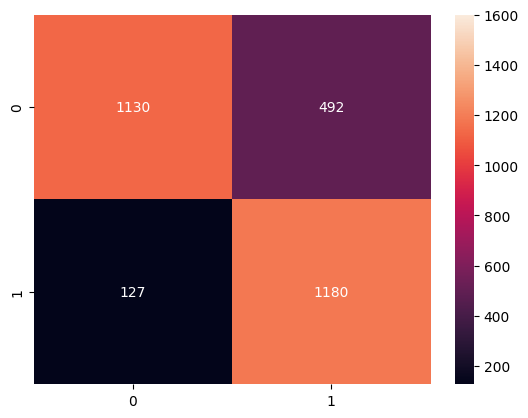

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

preds = model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=1600)